IMPORTING LIBRARIES

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from collections import Counter

In [2]:
from pyforest import *
from datetime import datetime
from scipy.stats import norm
from scipy import stats
from scipy.stats import skew
import matplotlib.lines as mlines
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
from sci_analysis import analyze
import pandas_profiling as pp

sns.set_style ("darkgrid" , {"axes.facecolor":".9"})
pd.options.display.float_format = '{:,.4f}' .format
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

READING THE DATASET

As the dataset consists of bad lines, we ingore those fields.

In [3]:
df = pd.read_csv('books.csv', error_bad_lines=False)
df.head(3)

<IPython.core.display.Javascript object>

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.5700,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.4900,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.4200,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic


In [4]:
books = df

SHAPE OF THE DATASET

In [5]:
books.shape

(11123, 12)

In [6]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7     num_pages         11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB


# DATA PREPROCESSING

In [7]:
books.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

 creating a categorical column for average_rating

In [8]:
def create_cat(i):
    if i >=0 and i <=1:
        return '0-1'
    if i >=1 and i <=2:
        return '1-2'
    if i >=2 and i <=3:
        return '2-3'
    if i >=3 and i <=4:
        return '3-4'
    if i >=4 and i <=5:
        return '4-5'

Classifing numeric and categorical columns

In [9]:
numerical = books.select_dtypes(['float64', 'int64']).columns.values.tolist()
categorical = books.select_dtypes(['object']).columns.values.tolist()
print('Numerical Columns\n\n',numerical)
print()
print('Categorical Columns\n\n',categorical)

Numerical Columns

 ['bookID', 'average_rating', 'isbn13', '  num_pages', 'ratings_count', 'text_reviews_count']

Categorical Columns

 ['title', 'authors', 'isbn', 'language_code', 'publication_date', 'publisher']


Descriptive Statistics

In [10]:
stats=books.describe().T
stats['Variance'] = books[numerical].var()
stats.T

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,"11,123.0000","11,123.0000","11,123.0000","11,123.0000","11,123.0000","11,123.0000"
mean,"21,310.8570",3.9341,"9,759,880,247,639.1816",336.4056,"17,942.8481",542.0481
std,"13,094.7273",0.3505,"442,975,846,058.3530",241.1526,"112,499.1535","2,576.6196"
min,1.0000,0.0000,"8,987,059,752.0000",0.0000,0.0000,0.0000
25%,"10,277.5000",3.7700,"9,780,345,453,803.5000",192.0000,104.0000,9.0000
50%,"20,287.0000",3.9600,"9,780,582,461,536.0000",299.0000,745.0000,47.0000
75%,"32,104.5000",4.1400,"9,780,872,208,045.5000",416.0000,"5,000.5000",238.0000
max,"45,641.0000",5.0000,"9,790,007,672,386.0000","6,576.0000","4,597,666.0000","94,265.0000"
Variance,"171,471,881.8133",0.1228,"196,227,600,191,113,673,048,064.0000","58,154.5892","12,656,059,531.6634","6,638,968.5087"


In [11]:
books.describe(exclude=[np.number])

<IPython.core.display.Javascript object>

,title,authors,isbn,language_code,publication_date,publisher
count,11123,11123,11123,11123,11123,11123
unique,10348,6639,11123,27,3679,2290
top,The Brothers Karamazov,P.G. Wodehouse,4063633381,eng,10/1/2005,Vintage
freq,9,40,1,8908,56,318


Finding Duplicates

In [12]:
duplicates = books.duplicated()
print('Number of duplicated rows = %d' % (duplicates.sum()))
books[duplicates]

Number of duplicated rows = 0


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher


Finding Null values

In [13]:
books.isnull().sum().values.any()

False

Finding Unique values

In [14]:
for i in books.columns:
    print('\n',i,'\n\n',books[i].unique())


 bookID 

 [    1     2     4 ... 45634 45639 45641]

 title 

 ['Harry Potter and the Half-Blood Prince (Harry Potter  #6)'
 'Harry Potter and the Order of the Phoenix (Harry Potter  #5)'
 'Harry Potter and the Chamber of Secrets (Harry Potter  #2)' ...
 'The Ice-Shirt (Seven Dreams #1)' 'Poor People'
 'Las aventuras de Tom Sawyer']

 authors 

 ['J.K. Rowling/Mary GrandPré' 'J.K. Rowling' 'W. Frederick Zimmerman' ...
 'C.S. Lewis/Ana Falcão Bastos'
 'C.S. Lewis/Pauline Baynes/Ana Falcão Bastos'
 'William T. Vollmann/Larry McCaffery/Michael Hemmingson']

 average_rating 

 [4.57 4.49 4.42 4.56 4.78 3.74 4.73 4.38 4.22 4.21 3.44 3.87 4.07 3.9
 3.83 3.86 3.91 3.93 4.59 4.5  4.36 4.53 3.84 3.72 4.   3.88 4.33 3.45
 3.76 3.6  4.06 4.17 3.55 3.98 4.13 3.95 4.24 4.34 3.92 4.23 3.75 3.94
 3.77 4.46 3.68 3.99 3.25 3.89 3.82 3.78 4.01 4.35 4.28 3.34 3.67 3.48
 3.5  3.62 4.27 3.39 4.12 4.08 4.05 3.85 2.99 4.19 3.71 4.2  3.65 3.4
 4.11 3.42 4.02 3.69 4.1  3.66 4.61 4.04 3.97 4.14 3.57 3.43 3.22

In [15]:
date = books.publication_date.tolist()
Month = []
Year = []
Month_Year = []
for i in date:
    a = i.split('/')
    a.pop(1)
    Month.append(int(a[0]))
    Year.append(a[1])
    Month_Year.append(a[0]+'/'+a[1])


In [16]:
#change to month
import datetime
Month_name = []
for i in Month:
    a=datetime.date(1900, i, 1).strftime('%B')
    Month_name.append(a)

In [17]:
books['Month'] = pd.Series(Month_name, index=books.index)
books['Year'] = pd.Series(Year, index=books.index)
books['Month_Year'] = pd.Series(Month_Year, index=books.index)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Removing data which is not a book

In [18]:
print('\nBooks with authors name as NOT A BOOK:',len(books[books['authors']=='NOT A BOOK']))


Books with authors name as NOT A BOOK: 5


In [19]:
books[books['authors']=='NOT A BOOK'].iloc[:,:3]

,bookID,title,authors
1061,3593,Murder by Moonlight & Other Mysteries (New Adv...,NOT A BOOK
1064,3599,The Unfortunate Tobacconist & Other Mysteries ...,NOT A BOOK
5474,19786,The Goon Show Volume 4: My Knees Have Fallen ...,NOT A BOOK
5475,19787,The Goon Show: Moriarty Where Are You?,NOT A BOOK
5476,19788,The Goon Show Volume 11: He's Fallen in the W...,NOT A BOOK


In [20]:
books = books[books['authors']!='NOT A BOOK']
print('\nBooks with authors name as NOT A BOOK:',len(books[books['authors']=='NOT A BOOK']))


Books with authors name as NOT A BOOK: 0


# DATA VISUALIZATION

In [21]:
df.columns = [x.split()[0] for x in df.columns]

In [22]:
df.describe(include=['O'])

,title,authors,isbn,language_code,publication_date,publisher,Month,Year,Month_Year
count,11123,11123,11123,11123,11123,11123,11123,11123,11123
unique,10348,6639,11123,27,3679,2290,12,87,613
top,The Brothers Karamazov,P.G. Wodehouse,4063633381,eng,10/1/2005,Vintage,September,2006,10/2006
freq,9,40,1,8908,56,318,1278,1700,243


In [23]:
df.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,"11,123.0000","11,123.0000","11,123.0000","11,123.0000","11,123.0000","11,123.0000"
mean,"21,310.8570",3.9341,"9,759,880,247,639.1816",336.4056,"17,942.8481",542.0481
std,"13,094.7273",0.3505,"442,975,846,058.3530",241.1526,"112,499.1535","2,576.6196"
min,1.0000,0.0000,"8,987,059,752.0000",0.0000,0.0000,0.0000
25%,"10,277.5000",3.7700,"9,780,345,453,803.5000",192.0000,104.0000,9.0000
50%,"20,287.0000",3.9600,"9,780,582,461,536.0000",299.0000,745.0000,47.0000
75%,"32,104.5000",4.1400,"9,780,872,208,045.5000",416.0000,"5,000.5000",238.0000
max,"45,641.0000",5.0000,"9,790,007,672,386.0000","6,576.0000","4,597,666.0000","94,265.0000"


In [24]:
import matplotlib.pyplot as plt
plt.rc('font', family='TakaoPGothic')
import seaborn as sns
sns.set_style('darkgrid')

In [25]:
df_new=df
df_new['lan_code2'] = df_new.language_code.apply(lambda x: 'eng' if 'en-' in x or 'eng' in x else x)
lan_code = df_new['lan_code2'].value_counts().reset_index()

Distribution of books in each of the languages

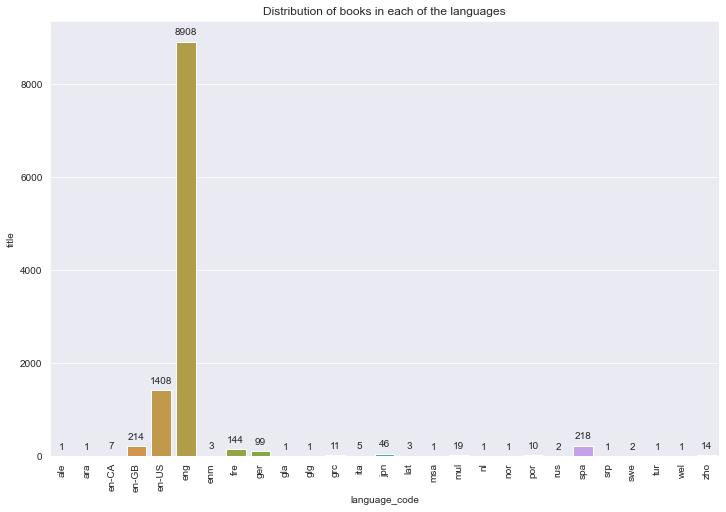

In [26]:
fig, ax = plt.subplots(figsize=(12,8))

dt = df_new.groupby('language_code').count()['title'].reset_index()
ax = sns.barplot(data= dt, x='language_code', y='title')
ax.set_title('Distribution of books in each of the languages')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.show()

UNIVARIATE ANALYSIS

<IPython.core.display.Javascript object>

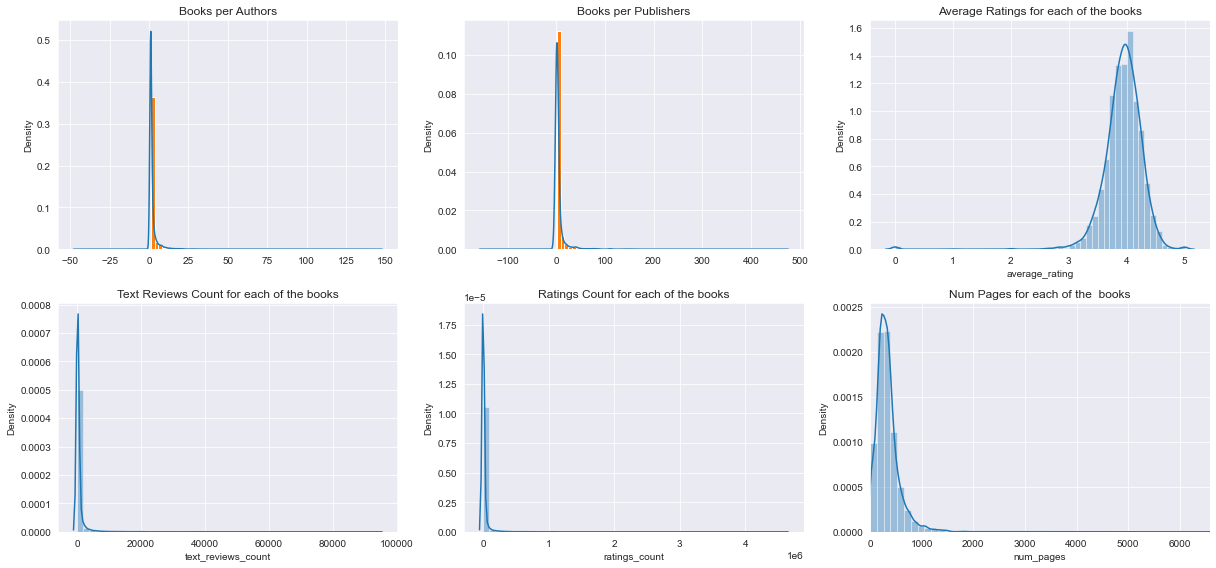

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(17,8))

# Distribution of books per authors
dist_authors = Counter([item for x in df_new['authors'].str.split('/') for item in x]).most_common()
dist_authors = pd.DataFrame(dist_authors).rename(columns={0: 'author', 1: 'freq'})
ax = dist_authors['freq'].plot.kde(ax=axes[0,0], legend=False, title='Books per Authors')
ax = dist_authors['freq'].hist(density=True, bins=40, ax=axes[0,0])
plt.xlim(0,max(dist_authors['freq']))

# # Distribution of books per publishers
dist_publisher = df_new['publisher'].value_counts().reset_index()
ax = dist_publisher['publisher'].plot.kde(ax=axes[0,1], legend=False, title='Books per Publishers')
ax = dist_publisher['publisher'].hist(density=True, bins=40, ax=axes[0,1])
plt.xlim(0,max(dist_publisher['publisher']))

# See the distribution of average_rating
ax = sns.distplot(df_new['average_rating'], ax=axes[0,2])
ax.set_title('Average Ratings for each of the books')

# Distribution of text_review_count per books
ax = sns.distplot(df_new['text_reviews_count'], ax=axes[1,0])
ax.set_title('Text Reviews Count for each of the books')

# Distribution of ratings_count per books
ax = sns.distplot(df_new['ratings_count'], ax=axes[1,1])
ax.set_title('Ratings Count for each of the books')

# See the distribution of num_pages
ax = sns.distplot(df_new['num_pages'], ax=axes[1,2])
ax.set_title('Num Pages for each of the  books')
plt.xlim(0, max(df_new['num_pages']))

plt.tight_layout()

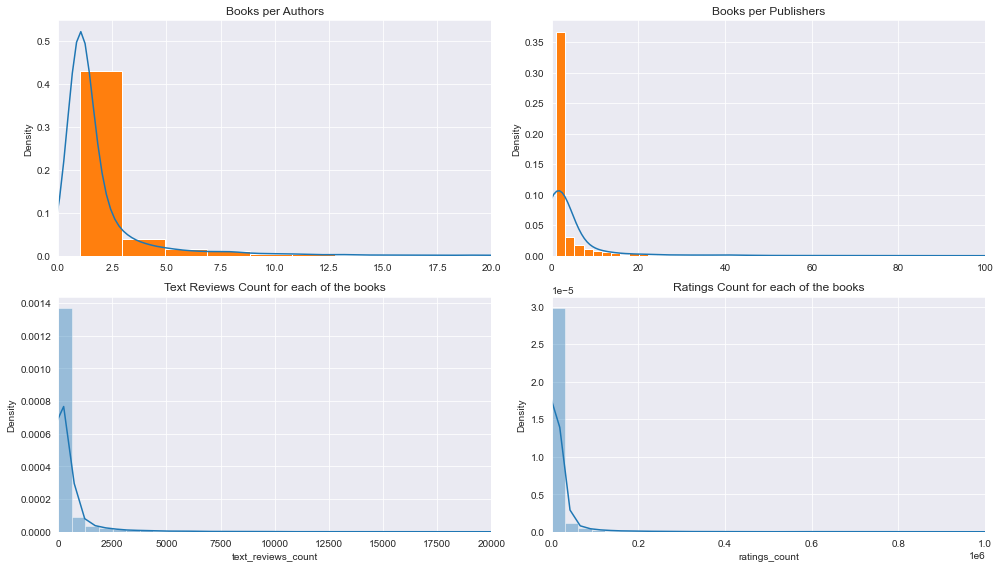

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(14,8))

# Distribution of books per authors
ax = dist_authors['freq'].plot.kde(ax=axes[0,0], legend=False, title='Books per Authors')
ax = dist_authors['freq'].hist(density=True, bins=50, ax=axes[0,0])
ax.set_xlim(0, 20)

# # Distribution of books per publishers
ax = dist_publisher['publisher'].plot.kde(ax=axes[0,1], legend=False, title='Books per Publishers')
ax = dist_publisher['publisher'].hist(density=True, bins=150, ax=axes[0,1])
ax.set_xlim(0,100)

# Distribution of text_review_count per books
ax = sns.distplot(df_new['text_reviews_count'], ax=axes[1,0], bins=150)
ax.set_title('Text Reviews Count for each of the books')
ax.set_xlim(0, 20000)

# Distribution of ratings_count per books
ax = sns.distplot(df_new['ratings_count'], ax=axes[1,1], bins=150)
ax.set_title('Ratings Count for each of the books')
ax.set_xlim(0, 1e6)
plt.tight_layout()

Distribution of Publish time

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

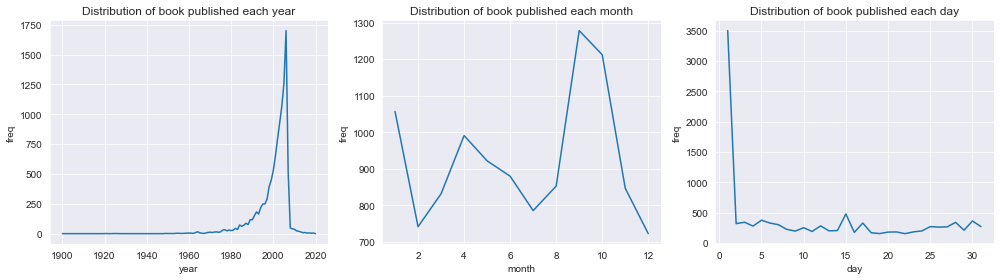

In [29]:
# Create new columns for each days, months and years
df_new['publish_year'] = df_new['publication_date'].str.split('/').apply(lambda x: x[2]).astype(int)
df_new['publish_month'] = df_new['publication_date'].str.split('/').apply(lambda x: x[0]).astype(int)
df_new['publish_day'] = df_new['publication_date'].str.split('/').apply(lambda x: x[1]).astype(int)

fig, axes = plt.subplots(1, 3, figsize=(14,4))
date = ['year', 'month', 'day']
for i, d in enumerate(date):
    pb_time = Counter(df_new['publish_'+d])
    pb_time = pd.DataFrame.from_dict(pb_time, orient='index').reset_index().rename(columns={'index':d, 0:'freq'})
    ax = sns.lineplot(data=pb_time, x=d, y='freq', ax=axes[i])
    ax.set_title('Distribution of book published each '+d)
    
plt.tight_layout()

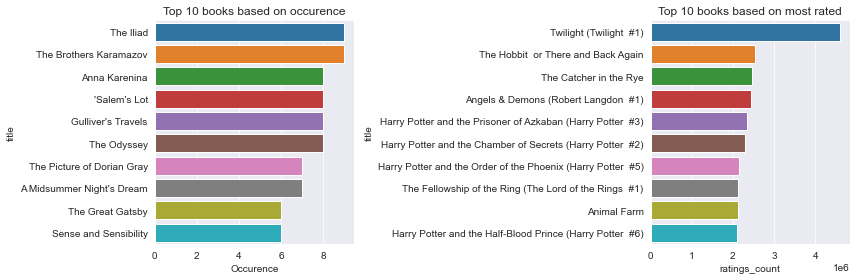

In [30]:
# Top 10 title based on the occurence and most ratings
fig, axes = plt.subplots(1, 2, figsize=(12,4))

dt = df.groupby('title').count()['bookID'].reset_index().sort_values(by='bookID', ascending=False).head(10)
ax = sns.barplot(data=dt, x="bookID", y="title", ax = axes[0])
ax.set(xlabel='Occurence', title='Top 10 books based on occurence')

dt = df_new.groupby('title').sum()['ratings_count'].reset_index().sort_values(by='ratings_count', ascending=False).head(10)
ax = sns.barplot(data=dt, x="ratings_count", y="title", ax = axes[1])
ax.set(xlabel='ratings_count', title='Top 10 books based on most rated')

plt.tight_layout()
plt.show()

In [31]:
# Create a temporary dataframe that only containst ratings count and list of authors
auth_df = df_new[['ratings_count', 'authors', 'lan_code2']]
auth_df['authors'] = auth_df['authors'].str.split('/')

# Get the total of ratings_count for each of the authors
rat_count, lan_list = [], []

for aut in dist_authors['author']:
    is_author = auth_df['authors'].apply(lambda x: True if aut in x else False)
    lang = auth_df[is_author]['lan_code2'].value_counts().reset_index().loc[0,:]['index']
    lan_list.append(lang)
    rat_count.append(sum(list(auth_df[is_author].ratings_count)))

# Create column that contains total ratings count for each of the authors
dist_authors['rat_count'] = rat_count
dist_authors['lan_code'] = lan_list

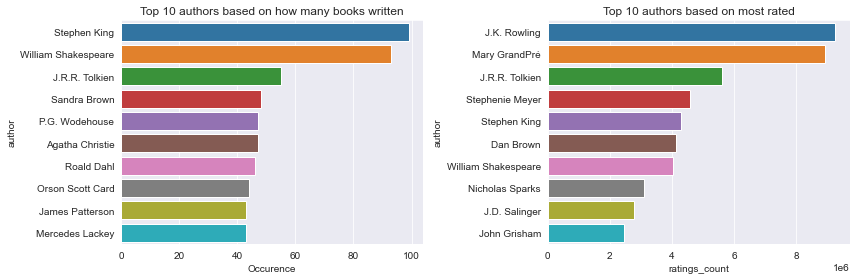

In [32]:
# Top 10 authors based on the occurence and most ratings 
fig, axes = plt.subplots(1, 2, figsize=(12,4))

ax = sns.barplot(data=dist_authors.sort_values(by='freq', ascending=False).head(10), x="freq", y="author", ax = axes[0])
ax.set(xlabel='Occurence', title='Top 10 authors based on how many books written')

ax = sns.barplot(data=dist_authors.sort_values(by='rat_count', ascending=False).head(10), x="rat_count", y="author", ax = axes[1])
ax.set(xlabel='ratings_count', title='Top 10 authors based on most rated')

plt.tight_layout()
plt.show()

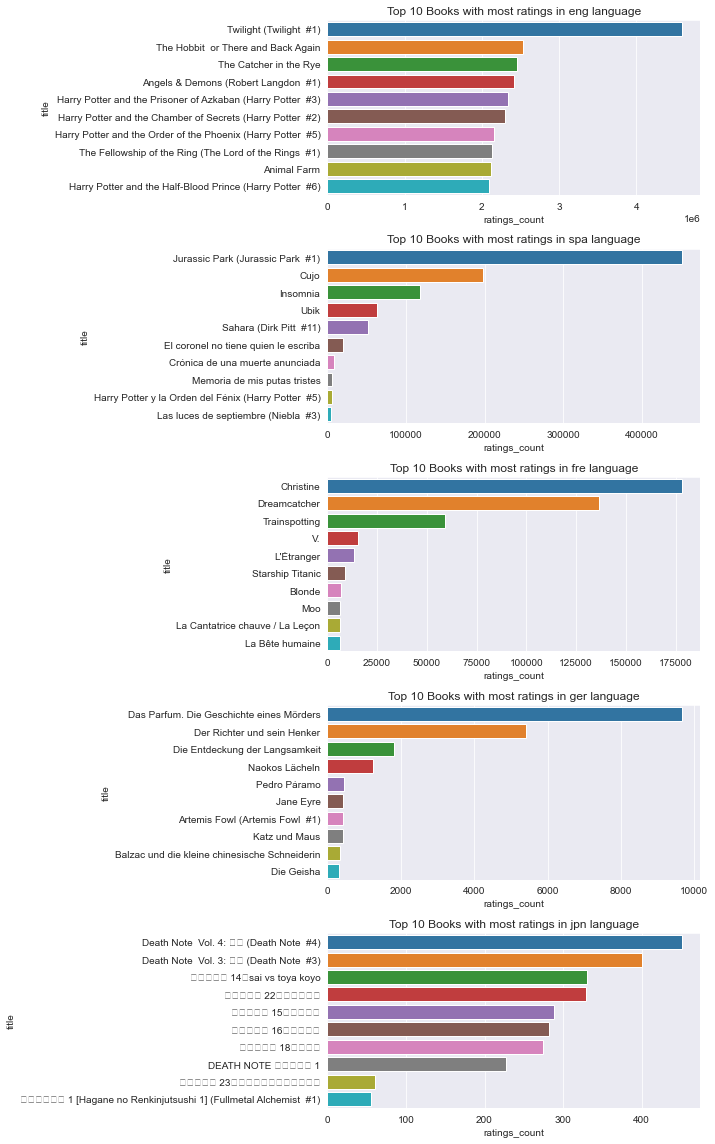

In [33]:
# Hide Warning Message
import warnings
warnings.filterwarnings('ignore')

# Top 10 Books with the most ratings count from top 5 language_code 
top_5_lan = list(lan_code.loc[:4,:]['index'])
fig, axes = plt.subplots(5, 1, figsize=(10,16))

for i, lan in enumerate(top_5_lan):
    dt = df_new[df_new.lan_code2 == lan].sort_values(by='ratings_count', ascending=False).head(10)
    ax = sns.barplot(data=dt, x='ratings_count', y='title', ax=axes[i])
    ax.set_title('Top 10 Books with most ratings in '+lan+' language')
plt.tight_layout()

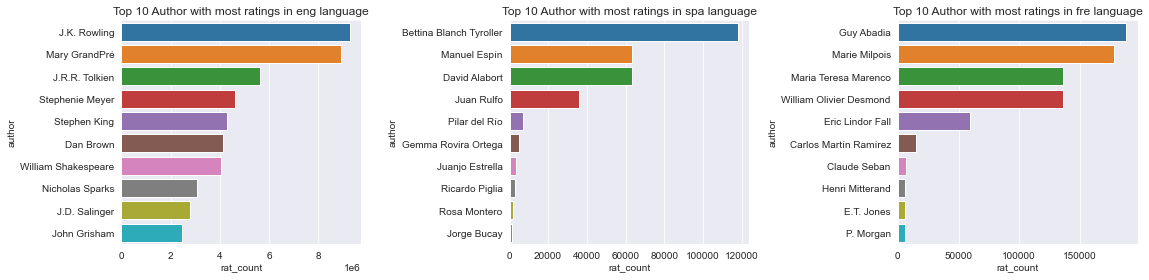

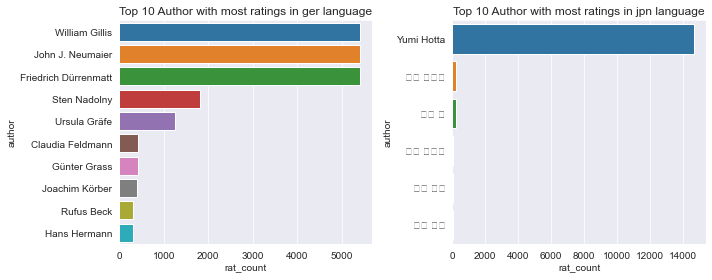

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))

for i, lan in enumerate(top_5_lan[:3]):
    dt = dist_authors[dist_authors['lan_code'] == lan].sort_values(by='rat_count', ascending=False).head(10)
    ax = sns.barplot(data=dt, x='rat_count', y='author', ax=axes[i])
    ax.set_title('Top 10 Author with most ratings in '+lan+' language')

plt.tight_layout()
fig, axes = plt.subplots(1, 2, figsize=(10,4))

for i, lan in enumerate(top_5_lan[3:]):
    dt = dist_authors[dist_authors['lan_code'] == lan].sort_values(by='rat_count', ascending=False).head(10)
    ax = sns.barplot(data=dt, x='rat_count', y='author', ax=axes[i])
    ax.set_title('Top 10 Author with most ratings in '+lan+' language')
plt.tight_layout()

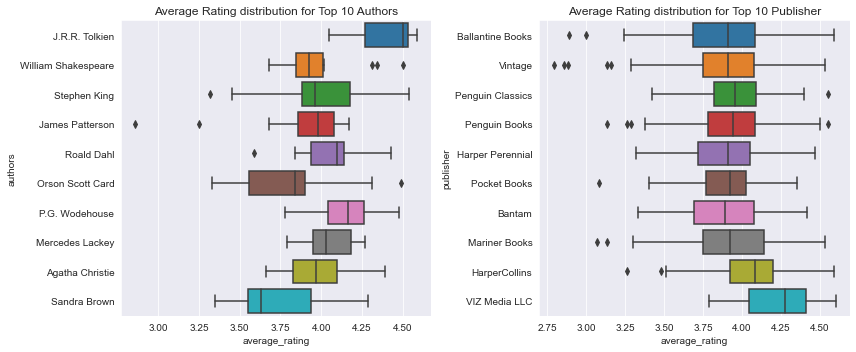

In [35]:
# Average rating for top 10 author with the most books
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Author
top_10_authors = list(dist_authors.sort_values(by='freq', ascending=False).head(10)['author'])
ax = sns.boxplot(data=df_new[df_new.authors.isin(top_10_authors)], x='average_rating', y='authors', ax=axes[0])
ax.set(title='Average Rating distribution for Top 10 Authors')

# Publisher
top_10_publishers = list(df_new.groupby('publisher').count()['title'].reset_index()\
.sort_values(by='title', ascending=False).head(10).publisher)

ax = sns.boxplot(data = df_new[df_new.publisher.isin(top_10_publishers)], x='average_rating', y='publisher', ax=axes[1])
ax.set(title='Average Rating distribution for Top 10 Publisher')

plt.tight_layout()
plt.show()

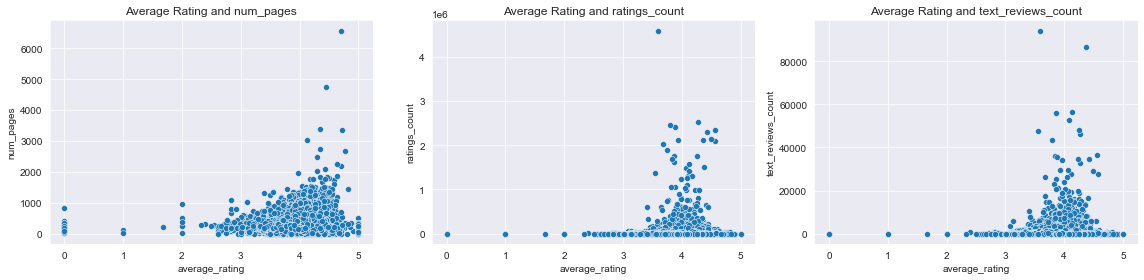

In [36]:
# Scatter plot 
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

stats = ['num_pages', 'ratings_count', 'text_reviews_count']
for i, st in enumerate(stats):
    ax = sns.scatterplot(data=df_new, x="average_rating", y=st, ax = axes[i])
    ax.set_title('Average Rating and '+st)
plt.tight_layout()    
plt.show()

Seems like there is no correlation between average_rating and num_pages, ratings_count and text_reviews_count

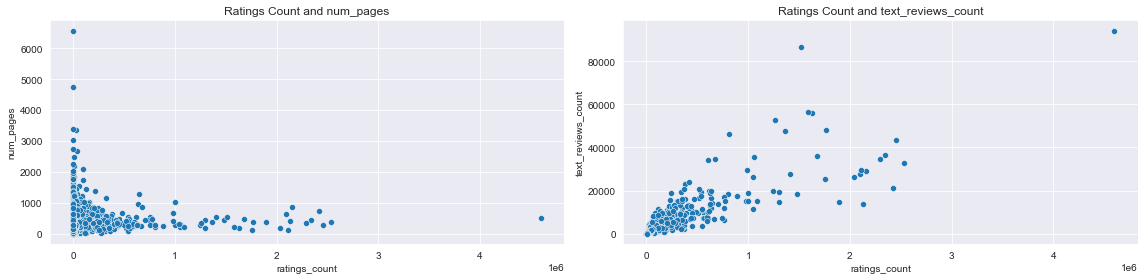

In [37]:
# Scatter plot 
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

stats = ['num_pages', 'text_reviews_count']
for i, st in enumerate(stats):
    ax = sns.scatterplot(data=df_new, x="ratings_count", y=st, ax = axes[i])
    ax.set_title('Ratings Count and '+st)
    
plt.tight_layout()
plt.show()

There is a positive correlation between text_reviews count and ratings_count but it's hard to tell about num_pages and ratings_count

In [38]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

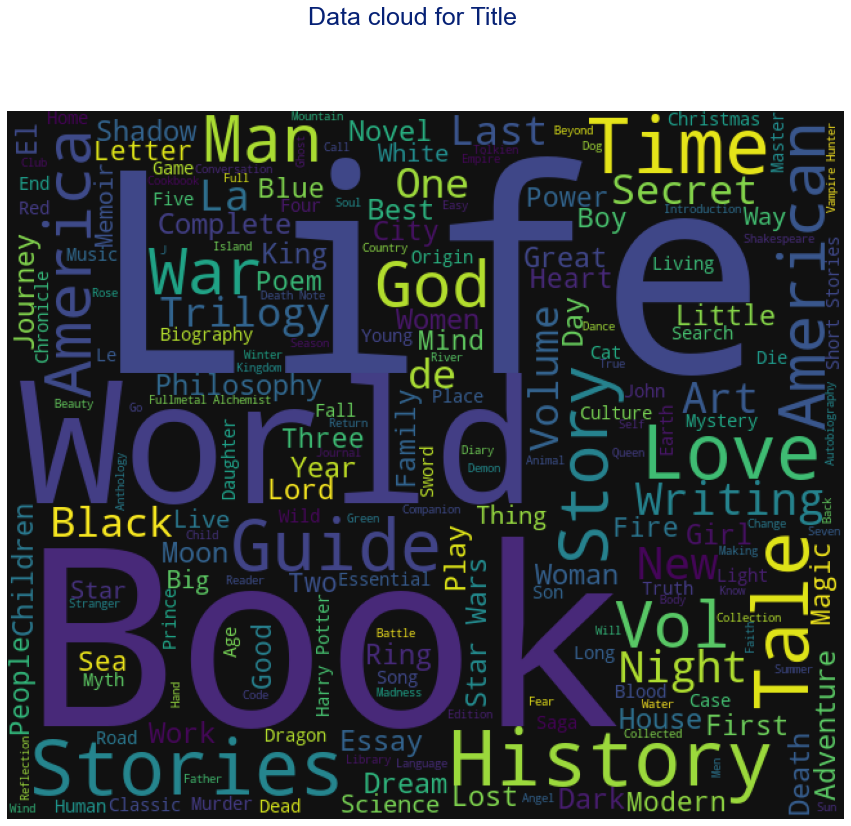

In [39]:
title_value = df.title.unique()

plt.subplots(figsize=(15,15))
wordcloud = WordCloud(
                          background_color='#1111',
                          width=650,
                          height=550,
                          stopwords=STOPWORDS,
                         ).generate(" ".join(title_value))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('graph.png')

plt.figtext(.5,.91,'Data cloud for Title', color='#062175', fontsize=25, ha='center')
plt.show()

RECOMENDATION SYSTEM USING COSINE SIMILARITY

In [40]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

In [41]:
import warnings
warnings.filterwarnings("ignore")

In [42]:
# removing the stop words
books_tfidf = TfidfVectorizer(stop_words='english')

# filling the missing values with empty string
df['authors'] = df['authors'].fillna('')

# computing TF-IDF matrix required for calculating cosine similarity
df_matrix = books_tfidf.fit_transform(df['title'])

In [43]:
df_matrix.shape

(11123, 11090)

In [44]:
cosine_similarity = linear_kernel(df_matrix, df_matrix)

In [45]:
indices = pd.Series(df['title'].index)

<IPython.core.display.Javascript object>

In [46]:
# Function to get the most similar books
def recommend(index, cosine_sim=cosine_similarity):
    id = indices[index]
    # Get the pairwsie similarity scores of all books compared to that book, 
    # sorting them and getting top 5
    similarity_scores = list(enumerate(cosine_sim[id]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:6]

    # Get the books index
    books_index = [i[0] for i in similarity_scores]

    # Return the top 5 most similar books using integer-location based indexing (iloc)
    return df['title'].iloc[books_index]

In [47]:
recommend(2)

4415     Harry Potter and the Chamber of Secrets (Harry...
6             Harry Potter Collection (Harry Potter  #1-6)
10675    Harry Potter and the Goblet of Fire (Harry Pot...
1        Harry Potter and the Order of the Phoenix (Har...
10674    Harry Potter and the Philosopher's Stone (Harr...
Name: title, dtype: object

RECOMMENDATION SYSTEM USING K-means clustering

In [48]:
book_data = df.copy()

In [49]:
def fun_only_author(text):
    arlen = text.split('/')
    return arlen[0]

In [50]:
book_data['only_author'] = book_data['authors'].apply(lambda x : fun_only_author(x))

In [51]:
len(book_data.only_author.unique())

4215

In [52]:
book_data.loc[ (book_data['average_rating'] >= 0) & (book_data['average_rating'] <= 1), 'rating_between'] = "between_0_to_1"
book_data.loc[ (book_data['average_rating'] > 1) & (book_data['average_rating'] <= 2), 'rating_between'] = "between_1_to_2"
book_data.loc[ (book_data['average_rating'] > 2) & (book_data['average_rating'] <= 3), 'rating_between'] = "between_2_to_3"
book_data.loc[ (book_data['average_rating'] > 3) & (book_data['average_rating'] <= 4), 'rating_between'] = "between_3_to_4"
book_data.loc[ (book_data['average_rating'] > 4) & (book_data['average_rating'] <= 5), 'rating_between'] = "between_4_to_5"

In [53]:
trial = book_data[['average_rating', 'ratings_count']]
data_model = np.asarray([np.asarray(trial['average_rating']), np.asarray(trial['ratings_count'])]).T
data_model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[4.570000e+00, 2.095690e+06],
       [4.490000e+00, 2.153167e+06],
       [4.420000e+00, 6.333000e+03],
       ...,
       [3.960000e+00, 8.200000e+02],
       [3.720000e+00, 7.690000e+02],
       [3.910000e+00, 1.130000e+02]])

In [54]:
from sklearn.cluster import KMeans

In [55]:
# Elbow Method

score = []
x = data_model
for cluster in range(1,41):
    kmeans = KMeans(n_clusters = cluster, init="k-means++", random_state=40)
    kmeans.fit(x)
    score.append(kmeans.inertia_)

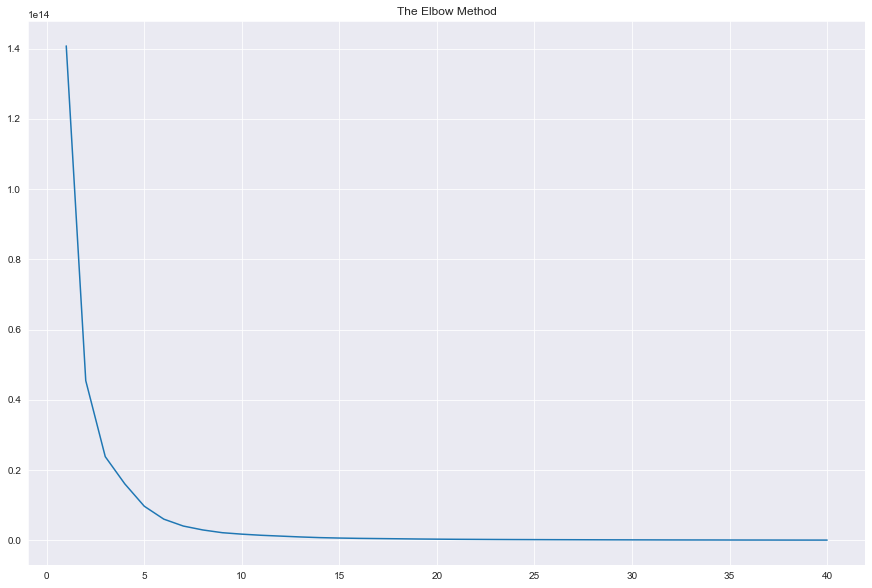

In [56]:
# plotting the score
plt.figure(figsize=(15, 10))
plt.plot(range(1,41), score)
plt.title('The Elbow Method')
# plt.xlabel('no of clusters')
# plt.ylabel('wcss')
plt.show()

In [57]:
rating_between_df = book_data['rating_between'].str.get_dummies(sep=",")
rating_between_df.head()

,between_0_to_1,between_1_to_2,between_2_to_3,between_3_to_4,between_4_to_5
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


In [58]:
lang_df = book_data['language_code'].str.get_dummies(sep=",")
lang_df.head()

,ale,ara,en-CA,en-GB,en-US,eng,enm,fre,ger,gla,glg,grc,ita,jpn,lat,msa,mul,nl,nor,por,rus,spa,srp,swe,tur,wel,zho
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [59]:
engine_features = pd.concat([rating_between_df, lang_df, book_data['average_rating'], book_data['ratings_count']], axis=1)
engine_features.head()

<IPython.core.display.Javascript object>

,between_0_to_1,between_1_to_2,between_2_to_3,between_3_to_4,between_4_to_5,ale,ara,en-CA,en-GB,en-US,eng,enm,fre,ger,gla,glg,grc,ita,jpn,lat,msa,mul,nl,nor,por,rus,spa,srp,swe,tur,wel,zho,average_rating,ratings_count
0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.5700,2095690
1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.4900,2153167
2,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.4200,6333
3,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.5600,2339585
4,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.7800,41428


In [60]:
from sklearn.preprocessing import MinMaxScaler

In [61]:
min_max_scaler = MinMaxScaler()
engine_features = min_max_scaler.fit_transform(engine_features)

In [62]:
from sklearn import neighbors

In [63]:
engine_model = neighbors.NearestNeighbors(n_neighbors=6, algorithm='ball_tree')

In [64]:
engine_model.fit(engine_features)

NearestNeighbors(algorithm='ball_tree', n_neighbors=6)

In [65]:
dist, idlist = engine_model.kneighbors(engine_features)

In [66]:
def book_recommendation_engine(book_name):
    book_list_name = []
    book_id = book_data[book_data['title'] == book_name].index
    book_id = book_id[0]
#     print('book_id', book_id)
    for newid in idlist[book_id]:
#         print(newid)
        book_list_name.append(book_data.loc[newid].title)
#         print(new_data.loc[newid].title)
    return book_list_name

In [67]:
book_list_name = book_recommendation_engine('The Da Vinci Code (Robert Langdon  #2)')
book_list_name

['The Da Vinci Code (Robert Langdon  #2)',
 'The Alchemist',
 'Of Mice and Men',
 'Romeo and Juliet',
 'Lord of the Flies',
 'Eat  Pray  Love']